In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

# 1. Подготовка данных

Загрузим и изучим данные:

In [2]:
# этот блок добавлен, потому что выполнял на ПК Windows, чтобы не ошибиться и не переписывать для работы на серере
path_data = os.path.normpath('/datasets/autos.csv')

In [3]:
data = pd.read_csv(path_data)

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Описания признаков: <br> <br>
Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


В данных имеются пропуски признаков: VehicleType (тип кузова), Gearbox (тип коробки передач), Model (модель), FuelType (тип топлива), NotRepaired (была машина в ремонте или нет)

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Также в данных есть и аномалии: цена 0, годы регистрации от 1000 до 9999, мощность от 0 до 20000, месяц регистрации 0.

Посмотрим на целевой признак:

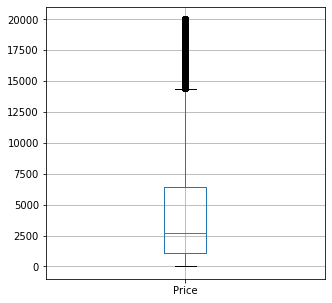

In [7]:
data.boxplot('Price', figsize=(5,5));

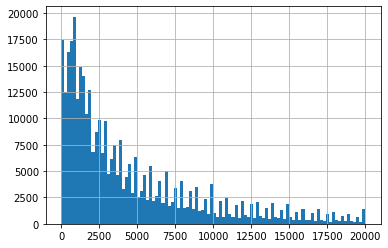

In [8]:
data['Price'].hist(bins=100);

In [9]:
data.query('Price > 14000')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
14,2016-03-21 12:57:01,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no,2016-03-21 00:00:00,0,4177,2016-04-06 07:45:42
33,2016-03-25 21:48:47,18000,sedan,2007,auto,218,3er,20000,5,petrol,bmw,no,2016-03-25 00:00:00,0,39179,2016-04-07 04:45:21
50,2016-03-30 08:50:37,14800,convertible,2008,manual,170,1er,125000,4,petrol,bmw,NaN,2016-03-30 00:00:00,0,48691,2016-04-07 00:17:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354259,2016-03-22 15:53:41,15000,sedan,2013,auto,115,focus,60000,10,gasoline,ford,no,2016-03-22 00:00:00,0,24340,2016-03-31 13:47:54
354279,2016-03-11 11:59:21,16500,suv,2013,manual,116,i_reihe,30000,9,gasoline,hyundai,no,2016-03-11 00:00:00,0,76297,2016-04-07 06:16:09
354286,2016-03-21 20:44:38,16500,coupe,1973,manual,200,other,150000,6,petrol,bmw,yes,2016-03-21 00:00:00,0,74722,2016-04-06 19:16:32
354306,2016-04-02 23:25:40,16999,wagon,2008,auto,269,a6,150000,7,gasoline,audi,no,2016-04-02 00:00:00,0,61440,2016-04-06 15:17:04


Судя по диаграмме размаха, выбросами можно считать значения цены более 14000 евро (около 1 млн. руб.). Максимальным значением цены является 20000 евро (около 1.5 млн. руб). Эти цены редко встречаются в выборке, однако являются вполне адекватными, и, чтобы модель знала об этих возможных объектах, оставим их. Удалим только объекты с ценой 0

In [10]:
data = data.query('Price != 0')

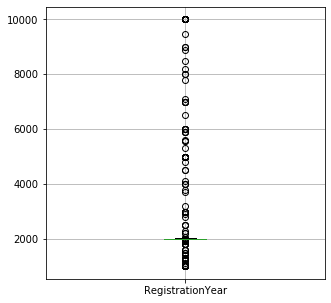

In [11]:
data.boxplot('RegistrationYear', figsize=(5,5));

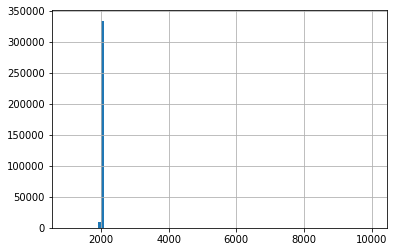

In [12]:
data['RegistrationYear'].hist(bins=100);

Годы регистрации имеют большой разброс

In [13]:
print('Год более 2020 имеют', data.query('RegistrationYear > 2020').shape[0], 'объектов')

Год более 2020 имеют 86 объектов


19 объектов - это не очень много, можно удалить их

In [14]:
data = data.query('RegistrationYear < 2020')

Посмотри, значения меньше какого являются выбросами снизу, судя по диаграмме размаха:

In [15]:
data['RegistrationYear'].quantile(q=0.25) - 1.5 * (data['RegistrationYear'].quantile(q=0.75) - data['RegistrationYear'].quantile(q=0.25))

1985.5

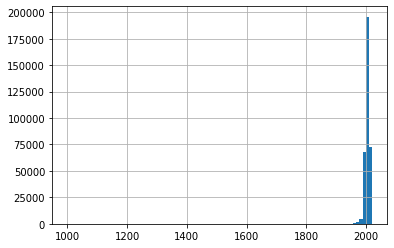

In [16]:
data['RegistrationYear'].hist(bins=100);

Машины возрастом более 35 лет являются выбросами, однако, такие машины всё ещё можно встретить в продаже. <br>
Судя по объявлениям сайта auto.ru в продаже могут быть раритетные автомобили 1929 г.в., большинство из них имеют довольно высокую стоимость. Оставим возможные значения года выпуска более 1930:


In [17]:
print('Год менее 1920 имеют', data.query('RegistrationYear < 1930').shape[0], 'объектов')

Год менее 1920 имеют 122 объектов


In [18]:
data = data.query('RegistrationYear > 1930')

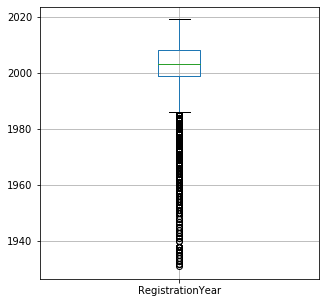

In [19]:
data.boxplot('RegistrationYear', figsize=(5,5));

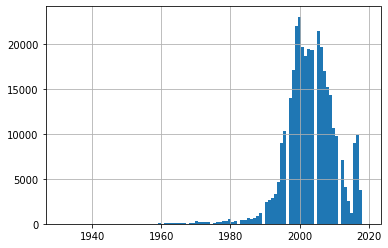

In [20]:
data['RegistrationYear'].hist(bins=100);

Посмотрим на зависимость цены от года выпуска:

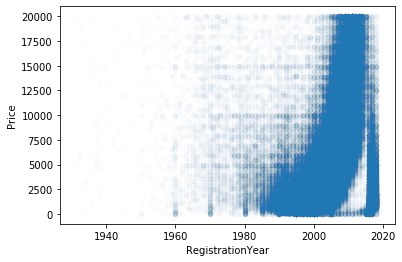

In [21]:
data.plot(kind='scatter', x='RegistrationYear',
            y='Price', alpha=0.01);

Посмотрим аномальные значения мощности

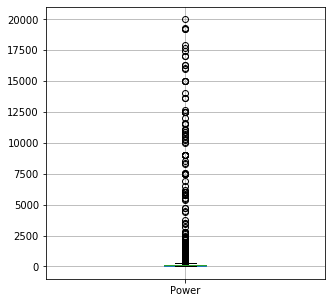

In [22]:
data.boxplot('Power', figsize=(5,5));

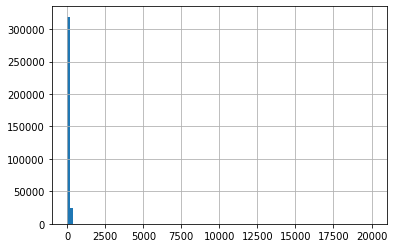

In [23]:
data['Power'].hist(bins=100);

In [24]:
1.5 * (data['Power'].quantile(q=0.75) - data['Power'].quantile(q=0.25)) + data['Power'].quantile(q=0.75)

254.0

Выбросами могут счтаться значения мощности более 254 л.с., однако, в продаже могут быть автомобили с мощностью до 800 л.с. (напрмер, Ferrari 812 или Mercedes-Benz G-Класс AMG II (W463)). Так что сначала удалим значения мощности более 800 л.с. и ещё раз посмотрим на данные:

In [25]:
print('Мощности более 800 л.с. ', data.query('Power > 800').shape[0], 'объектов')

Мощности более 800 л.с.  308 объектов


In [26]:
data = data.query('Power < 800')

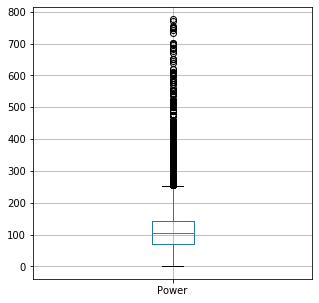

In [27]:
data.boxplot('Power', figsize=(5,5));

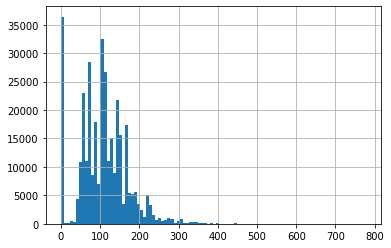

In [28]:
data['Power'].hist(bins=100);

In [29]:
data.query('Power > 700')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
6504,2016-03-14 15:54:34,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,NaN,2016-03-14 00:00:00,0,40721,2016-03-14 15:54:34
46941,2016-04-06 15:25:37,15000,coupe,2013,auto,751,NaN,10000,1,petrol,sonstige_autos,no,2016-04-06 00:00:00,0,60386,2016-04-06 15:25:37
56240,2016-04-05 08:53:32,490,small,1997,manual,750,fiesta,125000,7,NaN,ford,NaN,2016-04-05 00:00:00,0,32457,2016-04-07 11:44:53
161324,2016-03-21 15:50:54,9500,sedan,2014,manual,703,500,30000,10,petrol,fiat,NaN,2016-03-21 00:00:00,0,59227,2016-04-02 15:47:04
182210,2016-04-03 12:50:13,650,NaN,2016,manual,750,other,150000,8,NaN,fiat,no,2016-04-03 00:00:00,0,53844,2016-04-03 12:50:13
195787,2016-03-29 20:41:54,7000,small,2009,manual,776,punto,60000,9,electric,fiat,no,2016-03-29 00:00:00,0,86860,2016-04-06 06:45:29
231712,2016-03-11 18:36:24,1350,sedan,2000,manual,750,NaN,150000,9,NaN,volkswagen,yes,2016-03-11 00:00:00,0,38176,2016-03-12 23:16:50
246518,2016-04-04 20:48:09,2400,small,2004,manual,743,c2,125000,0,NaN,citroen,NaN,2016-04-04 00:00:00,0,17209,2016-04-06 23:17:39
252980,2016-03-07 12:53:51,2885,convertible,2009,manual,702,500,50000,8,petrol,fiat,yes,2016-03-07 00:00:00,0,99734,2016-03-07 17:19:43
281926,2016-03-14 22:53:33,400,small,1999,manual,754,fiesta,150000,0,petrol,ford,NaN,2016-03-14 00:00:00,0,22393,2016-03-17 14:46:09


Данные автомобили не могут иметь мощность более 700 л.с., значит мощность для них указана некорректно. Сделаем границу мощности 400 л.с.

In [30]:
data.query('Power > 400').shape[0]

377

In [31]:
data = data.query('Power < 400')

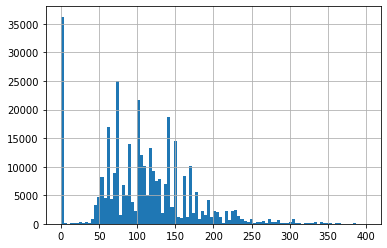

In [32]:
data['Power'].hist(bins=100);

Удалим объекты, для которых мощность указана 0 л.с.

In [33]:
data.query('Power == 0').shape[0]

36205

In [34]:
data.shape[0]

342649

Придётся удалить более 10% данных. Сначала посмотрим, влияет ли мощность на целевой признак:

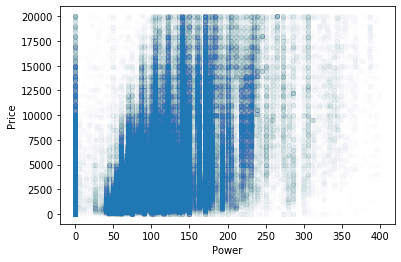

In [35]:
data.plot(kind='scatter', x='Power',
            y='Price', alpha=0.006);

Зависимость цены от мощности имеется, и больше всего она выражена у автомобилей, имеющих небольшую мощность

In [36]:
data = data.query('Power != 0')

In [37]:
data.shape[0]

306444

Теперь займёмся обработкой пропусков.

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306444 entries, 1 to 354368
Data columns (total 16 columns):
DateCrawled          306444 non-null object
Price                306444 non-null int64
VehicleType          285159 non-null object
RegistrationYear     306444 non-null int64
Gearbox              300387 non-null object
Power                306444 non-null int64
Model                294037 non-null object
Kilometer            306444 non-null int64
RegistrationMonth    306444 non-null int64
FuelType             286742 non-null object
Brand                306444 non-null object
NotRepaired          259479 non-null object
DateCreated          306444 non-null object
NumberOfPictures     306444 non-null int64
PostalCode           306444 non-null int64
LastSeen             306444 non-null object
dtypes: int64(7), object(9)
memory usage: 39.7+ MB


VehicleType имеет порядка 7% пропусков. Посмотрим на распределение значений:

In [39]:
data['VehicleType'].value_counts(normalize=True)

sedan          0.290775
small          0.245796
wagon          0.207607
bus            0.091935
convertible    0.065767
coupe          0.051136
suv            0.038266
other          0.008718
Name: VehicleType, dtype: float64

Оставим значение пропущеным, а позже воспользуемся OHE

Gearbox имеет порядка 2% пропущенных значений. Вероятно, схожий автомобиль с АКПП будет стоить дороже, чем автомобиль с МКПП. 2% пропусков - это не много, удалим их, однако, коллегам стоит сообщить о важности этого признака и, например, сделать выбор типа коробки передач обязательным при размещении объявления

In [40]:
data['Gearbox'].value_counts(normalize=True)

manual    0.799991
auto      0.200009
Name: Gearbox, dtype: float64

In [41]:
data = data.dropna(subset=['Gearbox'])

Пропуски в названии модели не важны.

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300387 entries, 1 to 354368
Data columns (total 16 columns):
DateCrawled          300387 non-null object
Price                300387 non-null int64
VehicleType          281033 non-null object
RegistrationYear     300387 non-null int64
Gearbox              300387 non-null object
Power                300387 non-null int64
Model                288776 non-null object
Kilometer            300387 non-null int64
RegistrationMonth    300387 non-null int64
FuelType             282207 non-null object
Brand                300387 non-null object
NotRepaired          256295 non-null object
DateCreated          300387 non-null object
NumberOfPictures     300387 non-null int64
PostalCode           300387 non-null int64
LastSeen             300387 non-null object
dtypes: int64(7), object(9)
memory usage: 39.0+ MB


Тип топлива пропущен примерно у 6% автомобилей

In [43]:
data['FuelType'].value_counts(normalize=True)

petrol      0.666996
gasoline    0.313263
lpg         0.016693
cng         0.001750
hybrid      0.000719
other       0.000330
electric    0.000248
Name: FuelType, dtype: float64

Большая часть автомобилей работает на бензине. Заполним пропуск на это типовое значение. Однако в будущем, для улучшения модели можно создать ещё одну модель для заполнения пропуска в типе топлива

In [44]:
data['FuelType'].fillna('petrol', inplace=True)

Остаётся порядка 15% пропущенных значений в признаке, определяющем, ремонтировался ли автомобиль

In [45]:
data['NotRepaired'].value_counts(normalize=True)

no     0.886572
yes    0.113428
Name: NotRepaired, dtype: float64

In [46]:
print('Период создания анкет:', data['DateCreated'].min(), data['DateCreated'].max())


Период создания анкет: 2015-03-20 00:00:00 2016-04-07 00:00:00


Анкеты были созданы в течении одного года, так что можно отталкиваться от года выпуска автомобиля при рассчёте стоимости. Однако, в будущем лучше использовать **возраст** автомобиля.

Посмотрим, правильно ли указаны бренды

In [47]:
data['Brand'].unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche',
       'saab', 'land_rover', 'trabant', 'lada'], dtype=object)

Удалим ненужные столбцы:
- DateCrawled, т.к. дата выгрузки анкеты не влияет
- Model, т.к. модели автомобилей часто меняются и их много. При обучении с учётом модели, модель МО работала бы лучше на известных моделях, но хуже на неизвестных, пришлось бы её чаще обучать к новым данным и скорость обучения была бы ниже (что важно в нашем случае)
- RegistrationMonth
- DateCreated
- NumberOfPictures, т.к. количество фотографий автомобиля не относится к его признакам
- PostalCode
- LastSeen

In [48]:
data = data.drop(['DateCrawled', 'Model', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1) 

In [49]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,150000,petrol,bmw,yes


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300387 entries, 1 to 354368
Data columns (total 9 columns):
Price               300387 non-null int64
VehicleType         281033 non-null object
RegistrationYear    300387 non-null int64
Gearbox             300387 non-null object
Power               300387 non-null int64
Kilometer           300387 non-null int64
FuelType            300387 non-null object
Brand               300387 non-null object
NotRepaired         256295 non-null object
dtypes: int64(4), object(5)
memory usage: 22.9+ MB


Закодируем категориальные признаки (VehicleType, Gearbox, FuelType, Brand, NotRepaired) кодировщиком OHE

In [51]:
data_ohe = pd.get_dummies(data, drop_first=True, dummy_na=True)

In [52]:
data_ohe

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Brand_nan,NotRepaired_yes,NotRepaired_nan
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,2016,150,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
354366,1199,2000,101,125000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354367,9200,1996,102,150000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [53]:
target = data_ohe['Price']
features = data_ohe.drop('Price', axis=1)

Сделаем масштабирование признаков:

In [54]:
scaler = StandardScaler()

In [55]:
features_scaled = scaler.fit_transform(features)

In [56]:
features_scaled.shape

(300387, 62)

Разделим выборку на тренировочную и валидационную:

In [57]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42)

### Вывод:
На данном этапе мы имеем две выборки: тренировочную и валидационную. Выборки отмасштабированы и закодированы OHE, по этому прменимы для большинства алгоритмов МО.

# 2. Обучение моделей

Обучим несколько разных моделей и сравним показатели, которые важны для заказчика: качество предсказания, скорость предсказания, время обучения. <br>
Вероятно, в данном случае, лучше всего подойдут алгоритмы градиентного бустинга (CatBoost), но для сравнения мы исследуем такие алгоритмы:
- линейная регрессия
- случайный лес
- градиентный бустинг CatBoost
- градиентный бустинг LightGBM 

Сравнивать качество моделей будем метрикой R2

## Линейная регрессия

In [58]:
%%time
model_linear_regression = LinearRegression(n_jobs=-1)
r2_linear_regression = cross_val_score(model_linear_regression, features_train, target_train, cv=5, scoring='r2').mean()
print('Среднее значение R2 модели линейной регрессии при валидации: {:.3}'.format(r2_linear_regression))

Среднее значение R2 модели линейной регрессии при валидации: 0.645
CPU times: user 11.1 s, sys: 3.27 s, total: 14.4 s
Wall time: 14.4 s


## Случайный лес

In [59]:
%%time

model_forest_RS = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators' : [i for i in range(15,200)],
    'max_depth' : [i for i in range(1,25)],
    'max_features' : [i for i in range(2, 62)]
}

CV_model_forest_RS = RandomizedSearchCV(estimator=model_forest_RS, param_distributions=param_grid, cv= 5, scoring='r2', n_jobs=-1, n_iter=20)
CV_model_forest_RS.fit(features_train, target_train)
CV_model_forest_RS.best_params_

depth_forest = CV_model_forest_RS.best_params_['max_depth']
estimators = CV_model_forest_RS.best_params_['n_estimators']
max_features = CV_model_forest_RS.best_params_['max_features']

r2_forest = CV_model_forest_RS.best_score_
print('Лучшее значение R2 случайного лес при кросс-валидации: ', r2_forest)
print('Лучший результат при проверке модели случайного леса получен: n_estimators = {:}, max_depth = {:}, max_features = {:}'
      .format(estimators, depth_forest, max_features))

Лучшее значение R2 случайного лес при кросс-валидации:  0.8751766790012016
Лучший результат при проверке модели случайного леса получен: n_estimators = 81, max_depth = 23, max_features = 50
CPU times: user 1h 33min 15s, sys: 11.5 s, total: 1h 33min 27s
Wall time: 1h 33min 51s


Лучшее значение R2 случайного лес при кросс-валидации:  0.8769986755836771 <br>
Лучший результат при проверке модели случайного леса получен: n_estimators = 154, max_depth = 21, max_features = 38 <br>
Wall time: 34min 55s

In [60]:
%%time
model_random_forest = RandomForestRegressor(n_estimators = 154, max_depth = 21, max_features = 38, random_state=42, n_jobs=-1)
r2_random_forest = cross_val_score(model_random_forest, features_train, target_train, cv=5, scoring='r2').mean()
print('Среднее значение R2 модели случайного леса при кросс-валидации: {:.3}'.format(r2_random_forest))

Среднее значение R2 модели случайного леса при кросс-валидации: 0.877
CPU times: user 12min 26s, sys: 2.46 s, total: 12min 28s
Wall time: 12min 32s


Модель случайного леса показала результаты лучше, чем линейная регрессия, однако затраты времени на обучение и предсказание во много раз больше

## Градиентный бустинг (CatBoost)

In [61]:
%%time
model_catboost = CatBoostRegressor(loss_function='RMSE', iterations=100, logging_level='Silent')
r2_catboost = cross_val_score(model_catboost, features_train, target_train, cv=5, scoring='r2').mean()
print('Среднее значение R2 модели градиентного бустинга CatBoost при кросс-валидации: {:.3}'.format(r2_catboost))

Среднее значение R2 модели градиентного бустинга CatBoost при кросс-валидации: 0.788
CPU times: user 1min 21s, sys: 6.29 s, total: 1min 27s
Wall time: 1min 37s


Значение R2 на кросс-валидации довольно близко к значению R2 случайного леса, при затраченном на обучение и пердсказание времени почти в 12 раз меньше

In [62]:
%%time
model_catboost2 = CatBoostRegressor(loss_function='RMSE', iterations=1000, logging_level='Silent')
r2_linear_regression2 = cross_val_score(model_catboost2, features_train, target_train, cv=5, scoring='r2').mean()
print('Среднее значение R2 модели градиентного бустинга CatBoost при кросс-валидации: {:.3}'.format(r2_linear_regression2))

Среднее значение R2 модели градиентного бустинга CatBoost при кросс-валидации: 0.859
CPU times: user 10min 13s, sys: 59.6 s, total: 11min 13s
Wall time: 11min 24s


In [63]:
%%time
model_catboost2 = CatBoostRegressor(loss_function='RMSE', iterations=10, logging_level='Silent')
r2_linear_regression2 = cross_val_score(model_catboost2, features_train, target_train, cv=5, scoring='r2').mean()
print('Среднее значение R2 модели градиентного бустинга CatBoost при кросс-валидации: {:.3}'.format(r2_linear_regression2))

Среднее значение R2 модели градиентного бустинга CatBoost при кросс-валидации: 0.306
CPU times: user 27.1 s, sys: 926 ms, total: 28.1 s
Wall time: 34 s


## Градиентный бустинг (LightGbm)

In [64]:
%%time
model_lgbmr = LGBMRegressor(n_jobs=-1, random_state=43)
r2_lgbmr = cross_val_score(model_lgbmr, features_train, target_train, cv=5, scoring='r2').mean()
print('Среднее значение R2 модели градиентного бустинга LGBM при кросс-валидации: {:.3}'.format(r2_catboost))

Среднее значение R2 модели градиентного бустинга LGBM при кросс-валидации: 0.788
CPU times: user 1min 26s, sys: 338 ms, total: 1min 27s
Wall time: 1min 28s


Градиентный бустинг LightGbm показал довольно хорошие результаты "из коробки", получив значение метрики R2 сопоставимое с CatBosst затратив на 35% меньше времени

# 3. Анализ моделей

Проверим модели на валидационной выборке:

In [65]:
model_linear_regression = LinearRegression(n_jobs=-1)
model_random_forest = RandomForestRegressor(n_estimators = 154, max_depth = 21, max_features = 38, random_state=42, n_jobs=-1)
model_catboost = CatBoostRegressor(loss_function='RMSE', iterations=100, logging_level='Silent')
model_lgbmr = LGBMRegressor(n_jobs=-1, random_state=43)

In [66]:
%%time
model_linear_regression.fit(features_train, target_train)

CPU times: user 3 s, sys: 613 ms, total: 3.61 s
Wall time: 3.59 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [67]:
%%time
model_random_forest.fit(features_train, target_train)

CPU times: user 2min 55s, sys: 285 ms, total: 2min 55s
Wall time: 2min 56s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
                      max_features=38, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=154, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [68]:
%%time
model_catboost.fit(features_train, target_train)

CPU times: user 18.8 s, sys: 1.49 s, total: 20.3 s
Wall time: 21.8 s


In [69]:
%%time
model_lgbmr.fit(features_train, target_train)

CPU times: user 20.5 s, sys: 127 ms, total: 20.6 s
Wall time: 20.7 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=43, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [70]:
%%time
predict_linear_regression = model_linear_regression.predict(features_valid)

CPU times: user 14.7 ms, sys: 129 µs, total: 14.8 ms
Wall time: 5.36 ms


In [71]:
%%time
predict_random_forest = model_random_forest.predict(features_valid)

CPU times: user 2.92 s, sys: 15.9 ms, total: 2.94 s
Wall time: 3 s


In [72]:
%%time
predict_catboost = model_catboost.predict(features_valid)

CPU times: user 819 ms, sys: 20.5 ms, total: 839 ms
Wall time: 821 ms


In [73]:
%%time
predict_lgbmr = model_lgbmr.predict(features_valid)

CPU times: user 695 ms, sys: 2.01 ms, total: 697 ms
Wall time: 668 ms


Посчитаем R2 на тестовой выборке для моделей:

In [74]:
print("Линейная регрессия R2 =", r2_score(target_valid, predict_linear_regression))

Линейная регрессия R2 = 0.6408791603001203


In [75]:
print("Случайный лес R2 =", r2_score(target_valid, predict_random_forest))

Случайный лес R2 = 0.8777433101480246


In [76]:
print("Градиентный бустинг CatBoost R2 =", r2_score(target_valid, predict_catboost))

Градиентный бустинг CatBoost R2 = 0.785964765685766


In [77]:
print("Градиентный бустинг LightGbm R2 =", r2_score(target_valid, predict_lgbmr))

Градиентный бустинг LightGbm R2 = 0.8558393085772587


## Вывод
Модель случайного леса не подходит для решения данной задачи, так как имеет гораздо более низкую скорость обучения, что является одним из критериев выбора модели для заказчика. <br>
Модель линейной регрессии сильно уступает в качестве остальным моделям, хотя и работает быстрее остальных и качество модели гораздо лучше случайной. <br>
Для решения данной задачи лучше всего подходят модели, основанные на алгоритмах градиентного бустинга. "Из коробки" они показали примерно одинаковые результаты на тестовой выборке, но модель LightGbm работает немного быстрее. Хотя в общем эти модели работают незначительно хуже модели случайного леса, их быстродействие гораздо выше.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей